# The BEM formulation used by OptimUS

 - The 3rd Chilean Symposium on Boundary Element Methods – A programming workshop on ultrasound simulations
 - Friday, November 8, 2024
 - Elwin van 't Wout
 - Pontificia Universidad Católica de Chile

The OptimUS library provides functionality to simulate acoustic wave propagation in unbounded domains with homogeneous scatterers. The computational backend is based on a boundary element method (BEM) that solves a boundary integral formulation of the Helmholtz equation. This notebook gives more information about the mathematics behind OptimUS.

## Import the OptimUS library

Load the OptimUS library.

In [1]:
import optimus

## Perform a standard OptimUS simulation

Let us perform a standard simulation of acoustic waves scattering at a penetrable sphere. Please follow the tutorial `Basic Model.ipynb` for more details.

In [2]:
frequency = 1000
direction = (1,1,0)
source = optimus.source.create_planewave(frequency, direction)
geometry = optimus.geometry.shapes.Sphere(element_size=0.4)
material_ext = optimus.material.load_material('water')
material_int = optimus.material.load_material('bone (cortical)')

In [3]:
model = optimus.model.create_default_model(source, geometry, material_ext, material_int)
model.solve()

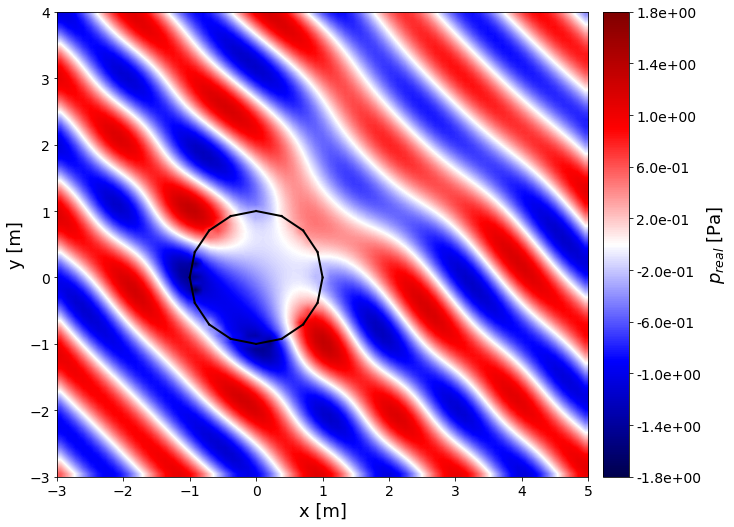

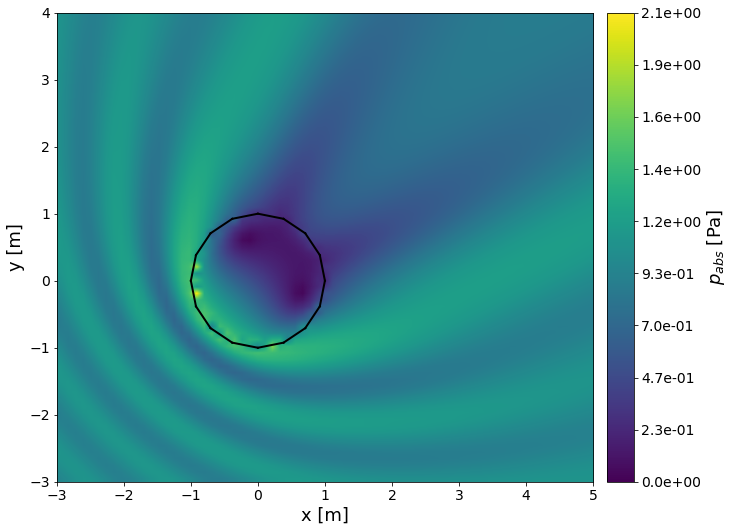

In [4]:
%matplotlib inline
postprocess_plane = optimus.postprocess.VisualisePlane(model)
postprocess_plane.create_computational_grid(resolution=(71, 71), bounding_box=(-3, 5, -3, 4))
postprocess_plane.compute_fields()
figs = optimus.postprocess.plot_pressure_field(postprocess_plane)

## Perform a BEM simulation

The acoustic wave propagation is modelled with harmonic wave fields that satisfy the Helmholtz equation. At the interfaces between homogeneous materials, the transmission conditions impose continuity of the pressure field and the normal particle velocity. Furthermore, the Sommerfeld radiation condition forces all scattered fields to travel towards infinity in the unbounded domains. The system of equations is given by
$$\begin{cases} -\nabla^2 p_\text{tot} - k_\text{ext}^2 p_\text{tot} = 0 & \text{in } \Omega_\text{ext}, \\ -\nabla^2 p_\text{int} - k_\text{int}^2 p_\text{int} = 0 & \text{in } \Omega_\text{int}, \\ p_\text{tot} = p_\text{int} & \text{on } \Gamma, \\ \nabla p_\text{tot} \cdot \mathbf{n} = \nabla p_\text{int} \cdot \mathbf{n} & \text{on } \Gamma, \\ \lim_{|\mathbf{x}| \to \infty} |\mathbf{x}| (\nabla p_\text{sca} \cdot \mathbf{x} - \imath k_\text{ext} p_\text{sca}) = 0 \end{cases}$$
Here, $p_\text{tot} = p_\text{sca} + p_\text{inc}$ are the total, scattered and incident pressure fields in the exterior domain $\Omega_\text{ext}$, $p_\text{int}$ the pressure field in the interior domain $\Omega_\text{int}$, $\mathbf{n}$ the unit outward normal at the interface $\Gamma$, $k$ the wavenumber and $\rho$ the density.

In [5]:
import bempp.api
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse.linalg import gmres

Let us define the material parameters for the BEM simulation. We need the wavenumber of both domains for the Green's function and the mass density in the transmission condition. Here, we use the same values as before for validation purposes.

In [6]:
k_ext = material_ext.compute_wavenumber(frequency)
k_int = material_int.compute_wavenumber(frequency)
rho_ext = material_ext.density
rho_int = material_int.density

The incident wave field is a plane wave travelling in a fixed direction, that is $$p_\text{inc} = e^{\imath k_\text{ext} \mathbf{d} \cdot \mathbf{x}}$$ where $\mathbf{d}$ has to be of unit size. We also need the normal derivative of the plane wave, which can be calculated analytically as $$\nabla p_\text{inc} \cdot \mathbf{n} = \imath k_\text{ext} (\mathbf{d} \cdot \mathbf{n}) e^{\imath k_\text{ext} \mathbf{d} \cdot \mathbf{x}}$$ for $\mathbf{n}$ the unit outward-pointing normal at the surface.

In [7]:
wavedirection = np.array([1,1,0])
wavedirection = wavedirection / np.linalg.norm(wavedirection)

def dirichlet_fun(x, n, domain_index, result):
    result[0] = np.exp(1j * k_ext * np.dot(wavedirection, x))
    return

def neumann_fun(x, n, domain_index, result):
    result[0] = 1j * k_ext * np.dot(wavedirection, n) * np.exp(1j * k_ext * np.dot(wavedirection, x))
    return

The triangular surface grid on a sphere can be created through an interface to the gmsh library. We only need to specify the mesh size for a unit sphere.

In [8]:
grid = bempp.api.shapes.sphere(h=0.4)

The boundary integral operators are discretised with a Galerkin method. Hence, we need to choose the type of basis and test functions in the weak formulation. Since we need the hypersingular operator, we will use continuous piecewise-linear (P1) elements everywhere.

In [9]:
space = bempp.api.function_space(grid, "P", 1)

The incident wave field is defined in the exterior domain, but needs to be mapped towards the surface for the BEM. These so-called Dirichlet and Neumann traces can be calculated with the `GridFunction` class of Bempp, which requires specifying the grid and the function to evaluate.

In [10]:
trace_dirichlet = bempp.api.GridFunction(space, fun=dirichlet_fun)
trace_neumann = bempp.api.GridFunction(space, fun=neumann_fun)

Now we are ready to create the boundary integral operators for the PMCHWT formulation
$$\begin{bmatrix} V_\text{ext} + \frac{\rho_\text{int}}{\rho_\text{ext}} V_\text{int} & -K_\text{ext} - K_\text{int} \\ T_\text{ext} + T_\text{int} & D_\text{ext} + \frac{\rho_\text{ext}}{\rho_\text{int}} D_\text{int} \end{bmatrix} \begin{bmatrix} \gamma_N^\text{ext} p_\text{tot} \\ \gamma_D^\text{ext} p_\text{tot} \end{bmatrix} = \begin{bmatrix} \gamma_D^\text{ext} p_\text{inc} \\ \gamma_N^\text{ext} p_\text{inc} \end{bmatrix}.$$ 
Here $$[V\psi](\mathbf{x}) = \iint_\Gamma G(\mathbf{x}, \mathbf{y}) \psi(\mathbf{y}) \,\mathrm{d}\mathbf{y}$$ is the single-layer boundary integral operator, $$[K\phi](\mathbf{x}) = \iint_\Gamma (\nabla_\mathbf{y} G(\mathbf{x}, \mathbf{y}) \cdot \mathbf{n}) \phi(\mathbf{y}) \,\mathrm{d}\mathbf{y}$$ is the double-layer boundary integral operator, $$[T\psi](\mathbf{x}) = \mathbf{n} \cdot \nabla_\textbf{x} \iint_\Gamma G(\mathbf{x}, \mathbf{y}) \psi(\mathbf{y}) \,\mathrm{d}\mathbf{y}$$ is the adjoint-double-layer boundary integral operator, and $$[D\phi](\mathbf{x}) = \mathbf{n} \cdot \nabla_\textbf{x} \iint_\Gamma (\nabla_\mathbf{y} G(\mathbf{x}, \mathbf{y}) \cdot \mathbf{n}) \phi(\mathbf{y}) \,\mathrm{d}\mathbf{y}$$ is the hypersingular boundary integral operator. The three-dimensional Green's function for the Helmholtz equation is given by $$G(\mathbf{x}, \mathbf{y}) = \frac{e^{\imath k \lvert \mathbf{x} - \mathbf{y} \rvert}}{4 \pi \lvert \mathbf{x} - \mathbf{y} \rvert}$$ with the wavenumber for the corresponding domain.

The Bempp library has various operators, among which are the Helmholtz kernels. These operators require specifying the domain, range, and dual-to-range spaces. The basis functions are taken from the domain space, the test functions from the dual-to-range space, and the range space is necessary to calculate the strong form of the operators. Also, specify the wavenumber, which is different in each domain.

In [11]:
sl_ext = bempp.api.operators.boundary.helmholtz.single_layer(space, space, space, k_ext)
dl_ext = bempp.api.operators.boundary.helmholtz.double_layer(space, space, space, k_ext)
ad_ext = bempp.api.operators.boundary.helmholtz.adjoint_double_layer(space, space, space, k_ext)
hs_ext = bempp.api.operators.boundary.helmholtz.hypersingular(space, space, space, k_ext)

sl_int = bempp.api.operators.boundary.helmholtz.single_layer(space, space, space, k_int)
dl_int = bempp.api.operators.boundary.helmholtz.double_layer(space, space, space, k_int)
ad_int = bempp.api.operators.boundary.helmholtz.adjoint_double_layer(space, space, space, k_int)
hs_int = bempp.api.operators.boundary.helmholtz.hypersingular(space, space, space, k_int)

The operators are set up but the matrices are not assembled yet. To create the discrete operators, we can either choose the weak or the strong formulation of the operator. The strong formulation includes mass preconditioning and is typically preferred because it accelerates the linear solver.

Notice that this part is computationally expensive.

In [12]:
sl_ext_discrete = sl_ext.strong_form()
dl_ext_discrete = dl_ext.strong_form()
ad_ext_discrete = ad_ext.strong_form()
hs_ext_discrete = hs_ext.strong_form()

sl_int_discrete = sl_int.strong_form()
dl_int_discrete = dl_int.strong_form()
ad_int_discrete = ad_int.strong_form()
hs_int_discrete = hs_int.strong_form()

We can now form the entire system matrix, which is the $2 \times 2$ block matrix. This can be handled with the `BlockedDiscreteOperator` of Bempp. Furthermore, each block is a linear combination of two boundary operators. Bempp handles these algebraic manipulations of the operators.

In [13]:
matrix = bempp.api.BlockedDiscreteOperator(
    [
        [sl_ext_discrete + (rho_int / rho_ext) * sl_int_discrete, -dl_ext_discrete - dl_int_discrete],
        [ad_ext_discrete + ad_int_discrete, hs_ext_discrete + (rho_ext / rho_int) * hs_int_discrete]
    ]
)

The right-hand-side vector consists of the Dirichlet and Neumann traces. We can retrieve them as the coefficients of the grid functions that store these traces. Notice that when the weak form is used, we need the projections.

In [14]:
rhs_vector = np.concatenate([trace_dirichlet.coefficients, trace_neumann.coefficients])

The system matrix stored in the variable `matrix` is a custom Bempp object, which as a `matvec()` attribute. Hence, the scipy linear solvers can use these objects for the matrix-vector multiply in the Krylov solvers. Depending on the size and conditioning of the matrix, this may be computationally expensive.

In [15]:
solution_vector, info = gmres(matrix, rhs_vector)

The solution vector is a numpy array which stores the Neumann and Dirichlet traces of the total field. Hence, we need to split the solution vector into halves to retrieve each component.

In [16]:
solution_vector_neumann, solution_vector_dirichlet = np.split(solution_vector, 2)
sol_neumann = bempp.api.GridFunction(space, coefficients=solution_vector_neumann)
sol_dirichlet = bempp.api.GridFunction(space, coefficients=solution_vector_dirichlet)

Having the solution vector available, we like to visualise the pressure field inside and outside the sphere. For this purpose, we need to specify the grid points on which to calculate these fields. Furthermore, we need to distinguish between the interior and exterior domain. In the case of a sphere, we can check the radius, but for more general domains this is challenging. OptimUS provides functionality to automatically detect interior domains.

In [17]:
Nx, Ny = (71, 71)
xmin, xmax, ymin, ymax = (-3, 5, -3, 4)

plot_grid = np.mgrid[xmin : xmax : Nx * 1j, ymin : ymax : Ny * 1j]
points = np.vstack((plot_grid[0].ravel(), plot_grid[1].ravel(), np.zeros(plot_grid[0].size)))
u_evaluated = np.zeros(points.shape[1], dtype=np.complex128)

x, y = points[:2]
idx_ext = np.sqrt(x**2 + y**2) > 1.0
idx_int = np.sqrt(x**2 + y**2) <= 1.0

points_exterior = points[:, idx_ext]
points_interior = points[:, idx_int]

Having the surface potentials of the pressure field calculated with the BEM, we like to postprocess the results and calculate the field in the volume. The representation formulas
$$\begin{cases} p_\text{sca} = -\mathcal{V}_\text{ext} \psi + \mathcal{K}_\text{ext} \phi, \\ p_\text{int} = \frac{\rho_\text{int}}{\rho_\text{ext}} \mathcal{V}_\text{int} \psi - \mathcal{K}_\text{int} \phi \end{cases}$$
provide the equations to calculate the fields.
Here, $\psi$ and $\phi$ are the Neumann and Dirichlet potentials from the BEM's solution vector, and
$$[\mathcal{V}\psi](\mathbf{x}) = \iint_\Gamma G(\mathbf{x}, \mathbf{y}) \psi(\mathbf{y}) \,\mathrm{d}\mathbf{y} \quad \mathbf{x} \notin \Gamma, \\ [\mathcal{K}\phi](\mathbf{x}) = \iint_\Gamma (\nabla_\mathbf{y} G(\mathbf{x}, \mathbf{y}) \cdot \mathbf{n}) \phi(\mathbf{y}) \,\mathrm{d}\mathbf{y} \quad \mathbf{x} \notin \Gamma$$
are the single-layer and double-layer potential integral operators.

Hence, we need four potential operators. Both the single-layer and double-layer potential integral operators corresponding to the interior and to the exterior domains. Notice that they map from the surface towards the grid points in the volume.

In [18]:
sl_pot_ext = bempp.api.operators.potential.helmholtz.single_layer(space, points_exterior, k_ext)
dl_pot_ext = bempp.api.operators.potential.helmholtz.double_layer(space, points_exterior, k_ext)
sl_pot_int = bempp.api.operators.potential.helmholtz.single_layer(space, points_interior, k_int)
dl_pot_int = bempp.api.operators.potential.helmholtz.double_layer(space, points_interior, k_int)

Having all operators and surface potentials ready, we can apply the representation formula to calculate the scattered and interior field.

In [19]:
psca = -sl_pot_ext * sol_neumann + dl_pot_ext * sol_dirichlet
pint = (rho_int / rho_ext) * (sl_pot_int * sol_neumann) - dl_pot_int * sol_dirichlet

The incident field can be calculated analytically in the exterior points.

In [20]:
pinc = np.exp(1j * k_ext * np.dot(wavedirection, points_exterior))

We now calculate the pressure field, which is the interior field on the interior points, and the sum of the incident and scattered field on the exterior points.

In [21]:
p_field = np.zeros(Nx*Ny, dtype='complex')
p_field[idx_ext] = pinc + psca.flatten()
p_field[idx_int] = pint.flatten()

The fields are now available in each visualisation point. However, this is a one-dimensional array. To plot the field with the `imshow` function of matplotlib, we need to reshape it to the size of the two-dimensional visualisation grid. Furthermore, the data needs to be rotated to follow the `imshow` conventions.

In [22]:
p_plot = p_field.reshape([Nx, Ny])
p_imshow = np.rot90(p_plot)

We can finally plot the pressure field with matplotlib.

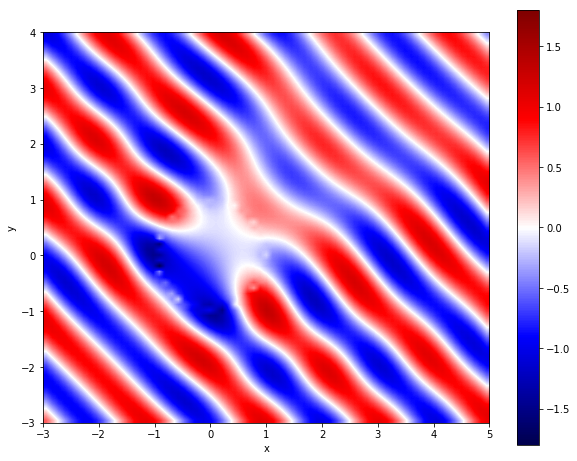

In [23]:
fig = plt.figure(figsize=(10, 8))
plt.imshow(np.real(p_imshow), clim=(-1.8, 1.8), extent=(xmin, xmax, ymin, ymax), cmap='seismic', interpolation="bilinear")
plt.xlabel("x")
plt.ylabel("y")
plt.colorbar()
plt.show()

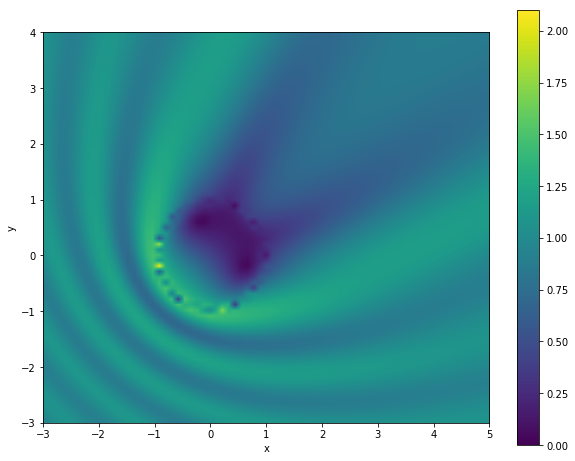

In [24]:
fig = plt.figure(figsize=(10, 8))
plt.imshow(np.abs(p_imshow), clim=(0, 2.1), extent=(xmin, xmax, ymin, ymax), interpolation="bilinear")
plt.xlabel("x")
plt.ylabel("y")
plt.colorbar()
plt.show()

We can indeed see that the calculated fields are equivalent to the fields calculated with OptimUS.

This notebook effectively showcased the mathematical techniques behind the acoustic simulations. All these technical details are hidden in the OptimUS library. If needed, an expert user can still access all mathematical details.

## Improve the convergence of the linear solver with preconditioning

The system matrix is typically solved with an iterative Krylov method. Within each iteration, a matrix-vector multiplication is performed, which can also be applied to a hierarchically compressed matrix. The number of iterations required to converge to a specific tolerance depends on the conditioning of the matrix. A common strategy to improve convergence is to apply preconditioning. That is, instead of solving $A\mathbf{x}=\mathbf{b}$, one solves $M^{-1}A\mathbf{x}=M^{-1}\mathbf{b}$ for a given matrix $M$. The choice of preconditioner $M$ is highly problem-dependent.

In the case of BEM, *operator preconditioning* is often very efficient. The idea of operator preconditioning is to design a continuous operator that yields maps between the same function spaces. Then, each operator is discretized independently. In the case of blocked matrices, this would be $$\begin{bmatrix} M_1 & 0 \\ 0 & M_2 \end{bmatrix} \begin{bmatrix} V_\text{ext} + \frac{\rho_\text{int}}{\rho_\text{ext}} V_\text{int} & -K_\text{ext} - K_\text{int} \\ T_\text{ext} + T_\text{int} & D_\text{ext} + \frac{\rho_\text{ext}}{\rho_\text{int}} D_\text{int} \end{bmatrix} \begin{bmatrix} \gamma_N^\text{ext} p_\text{tot} \\ \gamma_D^\text{ext} p_\text{tot} \end{bmatrix} = \begin{bmatrix} M_1 & 0 \\ 0 & M_2 \end{bmatrix} \begin{bmatrix} \gamma_D^\text{ext} p_\text{inc} \\ \gamma_N^\text{ext} p_\text{inc} \end{bmatrix}$$ for suitable operator preconditioners $M_1$ and $M_2$.

Notice that we have $V: H^{-1/2}(\Gamma) \to H^{1/2}(\Gamma)$, $K: H^{1/2}(\Gamma) \to H^{1/2}(\Gamma)$, $T: H^{-1/2}(\Gamma) \to H^{-1/2}(\Gamma)$ and $D: H^{1/2}(\Gamma) \to H^{-1/2}(\Gamma)$ for fractional Sobolev spaces $H^{-1/2}(\Gamma)$ and $H^{1/2}(\Gamma)$ on the surface.

At high frequencies, the matrix becomes increasingly large and its conditioning often deteriorates as well. A special family of preconditioner operators are the On-Surface Radiation Conditions (OSRC) operators. There are two of them, the Neumann-to-Dirichlet $V_\text{NtD}: H^{-1/2}(\Gamma) \to H^{1/2}(\Gamma)$ and the Dirichlet-to-Neumann $V_\text{DtN}: H^{1/2}(\Gamma) \to H^{-1/2}(\Gamma)$ operators. They are pseudodifferential operators than can be approximated with Padé series expansions and discretised with Galerkin methods. They are available in Bempp: `bempp.api.operators.boundary.helmholtz.osrc_ntd` and `bempp.api.operators.boundary.helmholtz.osrc_dtn`.

**TASK 1** Design a preconditioned system. Specifically, justify how to choose $M_1$ and $M_2$ as either the OSRC-NtD or OSRC-DtN operators, based on functional properties.

**TASK 2** Implement the preconditioned system and compare the number of GMRES iterations with the unpreconditioned system.

**TASK 3** Change the parameters of the OSRC operators to optimize the convergence.

**TASK 4** Increase the frequency, use a fixed number of elements per wavelength, and improve the convergence again with OSRC preconditioning.

**TASK 5** The OptimUS library also provides preconditioning strategies. Perform OSRC preconditioning with the OptimUS library and compare its performance with your implementation.